In [1]:
import numpy as np
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, random_split, RandomSampler
from PIL import Image

## Loading Data

In [2]:
# Loads training data and splits into training and validation set
path = 'asl_alphabet_train/asl_alphabet_train'
dataset = torchvision.datasets.ImageFolder(
        root=path,
        transform=torchvision.transforms.ToTensor()
    )

In [3]:
# 87,000 images in all; 29 classes; 3000 images for each class; each image 200x200
# It is not necessary to go through all 87,000 images so we will take out 57,000
val_size = 13050
test_size = 13050
train_size = 60900
taking_out_size = len(dataset) - val_size - test_size - train_size

train_ds, val_ds, test_ds, taken_out_ds = random_split(dataset, [train_size, val_size, test_size, taking_out_size])

# Provides iterable through datasets
train_batch_size = 150
val_batch_size = 50
test_batch_size = 10

# Holds 60,900 images; 70% of the dataset 
train_loader = torch.utils.data.DataLoader(
    train_ds,
    batch_size = train_batch_size,
    shuffle=True
)

# Holds 13,050 images; 15% of the dataset 
val_loader = torch.utils.data.DataLoader(
    val_ds,
    batch_size = val_batch_size,
    shuffle=True
)

# Holds 13,050 images; 15% of the dataset 
test_loader = torch.utils.data.DataLoader(
    test_ds,
    batch_size = test_batch_size,
    shuffle=True
)

## Take a look at the data
We can plot the image data to have a better understanding of it.

In [4]:
## class label related
classes = {0:'A', 1:'B', 2:'C', 3:'D', 4:'E', 5:'F', 6:'G', 7:'H', 8:'I', 9:'J', 10:'K', 11:'L', 12:'M', 13:'N', 14:'O', 15:'P', 16:'Q', 17:'R',
           18:'S', 19:'T', 20:'U', 21:'V', 22:'W', 23:'X', 24:'Y',25:'Z', 26:'DELETE', 27:'NOTHING', 28:'SPACE'}

def index_to_class_name(y):
    return classes[y]
def class_name_to_index(class_name):
    return classes.index(class_name)

In [5]:
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_single_image(data):
    # show a single image
    ## note that using matplotlib plotting function, we will have to reshape the data as (1,32,32,3)
    img = data.reshape(3,32,32).transpose(1,2,0)
    imgplot = plt.imshow(img)
def show_multiple_images(data, data_y, n_show=12, columns=4):
    ## given an array of data, show all of them as images
    fig=plt.figure(figsize=(8, 8))
    n = min(data.shape[0], n_show)
    rows = math.ceil(n/columns)
    for i in range(n):
        img = data[i].reshape(3,200,200).transpose(1,2,0)
        ax = fig.add_subplot(rows, columns, i+1) ## subplot index starts from 1 not 0
        class_name = index_to_class_name(data_y[i])
        ax.set_title(str(data_y[i])+": "+class_name)
        plt.imshow(img)
    plt.show()

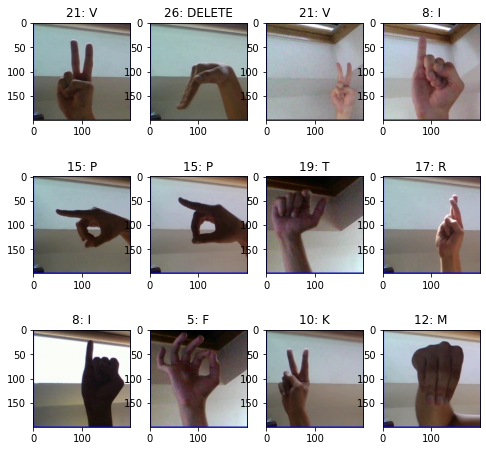

In [6]:
for batch_idx, (data, target) in enumerate(train_loader):
    show_multiple_images(data.numpy(), target.numpy())
    break

## Design Network Structure of a Convolutional Network

In [7]:
#implemented simplified version of AlexNet
class ConvNet(torch.nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 96, 11, stride=4)
        self.conv2 = torch.nn.Conv2d(96, 256, 5, stride=2)
        #pooling
        self.pool1 = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=0)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=0)
        # an affine operation: y = Wx + b
        self.fc1 = torch.nn.Linear(256 * 4 * 4, 256)
        self.fc2 = torch.nn.Linear(256, 128)
        self.fc3 = torch.nn.Linear(128, 29)
    def forward(self, x):
        x = torch.nn.functional.relu(self.conv1(x))
        x = self.pool1(x)
        x = torch.nn.functional.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 256 * 4 * 4)
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        # last layer doesn't have activation since we use pytorch's binary cross entropy loss
        x = self.fc3(x)
        return x

In [8]:
conv_net = ConvNet()

optimizer = optim.Adam(conv_net.parameters(), lr=1e-3)

criterion = nn.CrossEntropyLoss()

epochs = 10

## 3.2 Training the Convolutional Net model
1. We first initialize the neural network, and also the optimizer and the criterion (loss function)
2. We then start doing training iterations

In [9]:
# utility for getting prediction accuracy
def get_correct_and_accuracy(y_pred, y):
    # y_pred is the nxC prediction scores
    # give the number of correct and the accuracy
    n = y.shape[0]
    # find the prediction class label
    _ ,pred_class = y_pred.max(dim=1)
    correct = (pred_class == y).sum().item()
    return correct ,correct/n

In [10]:
train_loss_list = np.zeros(epochs)
train_accu_list = np.zeros(epochs)
val_loss_list = np.zeros(epochs)
val_accu_list = np.zeros(epochs)
# ----------------------------------------------------------------------------------------Training Set----------------------------------------------------------------------------------------#
for i in range(epochs):
    train_loss_all_batch = 0
    train_correct = 0
    val_correct = 0
    val_loss_all_batch = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        y_pred_batch = conv_net(data)
        # compute loss using ground truth y and the predicted scores
        train_loss = criterion(y_pred_batch, target)
        # backward propagation
        train_loss.backward()
        # add to ave_loss
        train_loss_all_batch += train_loss.item()  
        # take a gradient step
        optimizer.step()
        train_correct_batch, _ = get_correct_and_accuracy(y_pred_batch, target)
        train_correct += train_correct_batch
        # zero out gradient for optimizer, if you don't do this, gradients will accumulate
        optimizer.zero_grad()
    
    # logging training information   
    ave_train_loss = train_loss_all_batch / (len(train_ds)/train_batch_size)
    train_accu = train_correct / len(train_ds)
# ----------------------------------------------------------------------------------------Validation Set--------------------------------------------------------------------------------------#
    # compute validation loss and accuracy in order to prevent overfitting
    for batch_idx, (data, target) in enumerate(val_loader):
        y_val_pred = conv_net(data)
        val_loss = criterion(y_val_pred, target)
        val_loss_all_batch += val_loss.item()
        val_correct_batch, _ = get_correct_and_accuracy(y_val_pred, target)
        val_correct += val_correct_batch
        
    ave_val_loss = val_loss_all_batch/ (len(val_ds)/val_batch_size)
    val_accu = val_correct / len(val_ds)
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------#
    print("Iter %d ,Train loss: %.3f, Train acc: %.3f, Val loss: %.3f, Val acc: %.3f" 
          %(i ,ave_train_loss, train_accu, ave_val_loss, val_accu))
    
    # add to the logs so that we can use them later for plotting
    train_loss_list[i] = ave_train_loss
    train_accu_list[i] = train_accu
    val_loss_list[i] = ave_val_loss
    val_accu_list[i] = val_accu

Iter 0 ,Train loss: 1.606, Train acc: 0.502, Val loss: 0.493, Val acc: 0.841
Iter 1 ,Train loss: 0.306, Train acc: 0.897, Val loss: 0.152, Val acc: 0.955
Iter 2 ,Train loss: 0.120, Train acc: 0.960, Val loss: 0.128, Val acc: 0.958
Iter 3 ,Train loss: 0.053, Train acc: 0.983, Val loss: 0.028, Val acc: 0.992
Iter 4 ,Train loss: 0.055, Train acc: 0.983, Val loss: 0.050, Val acc: 0.983
Iter 5 ,Train loss: 0.043, Train acc: 0.986, Val loss: 0.114, Val acc: 0.962
Iter 6 ,Train loss: 0.040, Train acc: 0.987, Val loss: 0.081, Val acc: 0.976
Iter 7 ,Train loss: 0.039, Train acc: 0.988, Val loss: 0.036, Val acc: 0.989
Iter 8 ,Train loss: 0.024, Train acc: 0.993, Val loss: 0.015, Val acc: 0.995
Iter 9 ,Train loss: 0.018, Train acc: 0.994, Val loss: 0.028, Val acc: 0.992


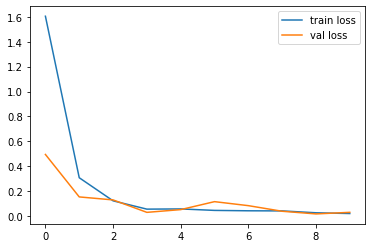

In [11]:
## plot training loss versus validation loss
x_axis = np.arange(epochs)
plt.plot(x_axis, train_loss_list, label='train loss')
plt.plot(x_axis, val_loss_list, label='val loss')
plt.legend()
plt.show()

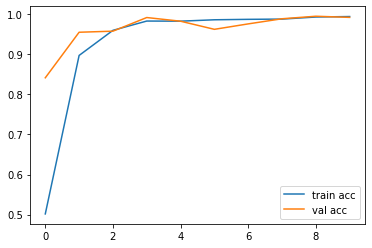

In [12]:
## plot training accuracy versus validation accuracy
plt.plot(x_axis, train_accu_list, label='train acc')
plt.plot(x_axis, val_accu_list, label='val acc')
plt.legend()
plt.show()

## Report testing performance
We want run the trained model on test data to see how well it does

In [13]:
## test predictive performance on the test set and report final performance
n_test_correct = 0
for batch_idx, (data, target) in enumerate(test_loader):
    test_pred = conv_net(data)
    test_correct, test_accu = get_correct_and_accuracy(test_pred, target)
    n_test_correct += test_correct
print("Test accuracy: ", n_test_correct/len(test_ds))

Test accuracy:  0.9946360153256705


In [18]:
torch.save(conv_net.state_dict(), 'model.pth')